# Network Analysis on Auckland road data
### Import packages

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon, Point
from shapely.ops import transform
import pyproj
import networkx as nx
import math
import matplotlib.pyplot as plt
from pyproj import CRS
import itertools

### Generating or importing the road network

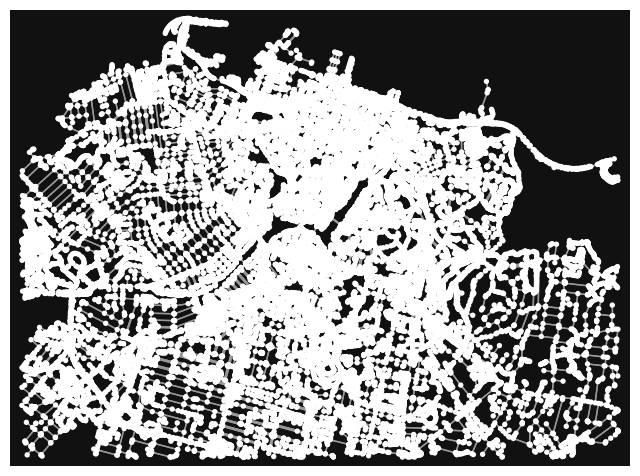

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [22]:
Gsmol = ox.graph.graph_from_address("Auckland, New Zealand", network_type="walk", simplify = False, dist =4000)
ox.plot_graph(Gsmol)

In [33]:
# Add speed and travel time
Gsmol = ox.add_edge_speeds(Gsmol)
Gsmol = ox.add_edge_travel_times(Gsmol)

In [34]:
#ox.io.save_graph_geopackage(Gsmol, "data/network_analysis/sample_network.gpkg")

### Nearest distances

# Adding other data

### Import the train stations in Auckland
The IDW was done in R. Code in the file data-prep.R

In [35]:
# Connect the supply points to the graph
#allstations = gpd.read_file("data/transport/public_transport/trains_auckland_with_distances_on_network.gpkg")

stations = gpd.read_file("data/transport/public_transport/sample_stations.gpkg")
stations['lon'] = stations['geometry'].x
stations['lat'] = stations['geometry'].y
stations["node"] = stations.geometry.apply(lambda x: ox.distance.nearest_nodes(Gsmol, x.x, x.y))
stations = gpd.GeoDataFrame(stations, geometry = stations.geometry)
stations

,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTYPE,STOPLAT,STOPLON,PARENTSTATION,MODE,lon,lat,u,v,dist,geometry,node
0,11,277,277,Grafton Train Station,None,Stop,-36.865612,174.769840,None,Train,174.769840,-36.865612,2765835305,2765835293,0,POINT (174.76984 -36.86561),3591613174
1,19,133,133,Britomart Train Station,None,Stop,-36.844291,174.768480,None,Train,174.768480,-36.844291,8808664536,8808664534,0,POINT (174.76848 -36.84429),8808664542
2,36,140,140,Parnell Train Station,None,Stop,-36.854728,174.777399,None,Train,174.777399,-36.854728,8628536361,3926522434,0,POINT (174.77740 -36.85473),8628536361
3,40,135,135,The Strand Train Station,None,Stop,-36.848536,174.779341,None,Train,174.779341,-36.848536,2981998375,7994688057,0,POINT (174.77934 -36.84854),7994688052


### Import the grid of urban Auckland including census variables
The IDW was done in R. Code in the file data-prep.R

In [36]:
# Connect the demand points to the graph
grid = gpd.read_file("data/geographic/grids/sample_grid_all.gpkg")
grid = gpd.GeoDataFrame(grid, geometry = grid.geometry)
grid = grid.to_crs(stations.crs)
grid['lon'] = grid['geometry'].x
grid['lat'] = grid['geometry'].y
grid["node"] = grid.geometry.apply(lambda x: ox.distance.nearest_nodes(Gsmol, x.x, x.y))                                                                         

grid.head(3)

,geometry,lon,lat,node
0,POINT (174.76739 -36.85513),174.767391,-36.855133,8605758309
1,POINT (174.76867 -36.85514),174.768671,-36.855141,1210037505
2,POINT (174.76995 -36.85515),174.769951,-36.855149,7210661923


In [37]:
nodes_proj, edges_proj = ox.graph_to_gdfs(Gsmol, nodes=True, edges=True)

In [50]:
grid

,geometry,lon,lat,node
0,POINT (174.76739 -36.85513),174.767391,-36.855133,8605758309
1,POINT (174.76867 -36.85514),174.768671,-36.855141,1210037505
2,POINT (174.76995 -36.85515),174.769951,-36.855149,7210661923
3,POINT (174.77123 -36.85516),174.771231,-36.855157,25770127
4,POINT (174.77251 -36.85516),174.772511,-36.855165,7611758390
...,...,...,...,...
124,POINT (174.77262 -36.84385),174.772618,-36.843850,4331930913
125,POINT (174.77390 -36.84386),174.773898,-36.843858,648872221
126,POINT (174.77518 -36.84387),174.775178,-36.843866,7961461402
127,POINT (174.77646 -36.84387),174.776458,-36.843874,7961461400


In [51]:
grid1 = grid.iloc[0:1]
grid1

,geometry,lon,lat,node
0,POINT (174.76739 -36.85513),174.767391,-36.855133,8605758309


In [123]:
for pidx, point in enumerate(grid1.itertuples()):
    paths = []
    distances = []
    for sidx, station in enumerate(stations.itertuples()):
        # get path
        paths.append(grid1.node.apply(lambda x: ox.shortest_path(Gsmol, x, stations['node'].iloc[sidx], weight='travel_time')))
        #path = 
        
        # get path length
        #distances.append(sum(ox.utils_graph.get_route_edge_attributes(Gsmol, paths.iloc[sidx,0], 'length')))
        
        print("Doing point", pidx, ". Distance to nearest station: ", station.STOPNAME, " is ", distances)
        

Doing point 0 . Distance to nearest station:  Grafton Train Station  is  []
Doing point 0 . Distance to nearest station:  Britomart Train Station  is  []
Doing point 0 . Distance to nearest station:  Parnell Train Station  is  []
Doing point 0 . Distance to nearest station:  The Strand Train Station  is  []


In [124]:
paths = pd.DataFrame(paths)
paths

,0
node,"[8605758309, 8605758308, 8605792822, 860579282..."
node,"[8605758309, 8605758310, 8605758311, 860575831..."
node,"[8605758309, 8605758310, 8605758311, 860575831..."
node,"[8605758309, 8605758310, 8605758311, 860575831..."


In [119]:
#paths.iloc[0,0] Continue here!

In [143]:
for pidx, point in enumerate(grid1.itertuples()):
    distances = []
    for sidx, station in enumerate(stations.itertuples()):
        # get distances
        dist = sum(ox.utils_graph.get_route_edge_attributes(Gsmol, paths.iloc[sidx,0], 'length'))
        
        dict_station_dist = {}
        keys=[]
        values=[]
        keys.append(station.STOPNAME)
        values.append(dist)

        for key, value in zip(keys, values):
            dict_station_dist[key] = value

        closest_station = min(dict_station_dist, key=dict_station_dist.get)
        minimum_distance = min(dict_station_dist.values())
        
        grid1['closest_station'].iloc[pidx] = closest_station
        grid1['dist'] = minimum_distance

        print("Doing point", pidx, ". Distance to nearest station: ", closest_station, " is ", minimum_distance)
        

Doing point 0 . Distance to nearest station:  Grafton Train Station  is  1766.871
Doing point 0 . Distance to nearest station:  Britomart Train Station  is  1422.9719999999998
Doing point 0 . Distance to nearest station:  Parnell Train Station  is  1814.6880000000003
Doing point 0 . Distance to nearest station:  The Strand Train Station  is  1489.8150000000003


/var/folders/v5/mcnrdbxj26l_3pq9rm9nds580000gn/T/ipykernel_4823/634247980.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid1['closest_station'].iloc[pidx] = closest_station
/opt/miniconda3/envs/ox/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/v5/mcnrdbxj26l_3pq9rm9nds580000gn/T/ipykernel_4823/634247980.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

In [144]:
grid1

,geometry,lon,lat,node,path,closest_station,dist
0,POINT (174.76739 -36.85513),174.767391,-36.855133,8605758309,"[8605758309, 8605758310, 8605758311, 860575831...",The Strand Train Station,1489.815


In [127]:
distances = pd.DataFrame(distances)
distances

,0
0,1766.871
1,1422.972
2,1814.688
3,1489.815


In [ ]:
# define function for the nearest neighbour
def nearest_node(a,b):
    nearest_node,dist=ox.distance.nearest_nodes(Gsmol, (a,b), return_dist=True, method = 'euclidean')  
    return nearest_node, dist

In [10]:
stations = stations.to_crs(grid.crs)

In [19]:
for pidx, point in enumerate(grid.itertuples()):
    orig_node, dist_origin_to_edge = ox.distance.nearest_nodes(Gsmol, point.geometry.x, point.geometry.y, return_dist=True) 
    o_closest = nodes_proj.loc[orig_node]
    
    for sidx, station in enumerate(stations.itertuples()):
        target_node, dist_target_to_edge = ox.distance.nearest_nodes(Gsmol, station.lon, station.lat, return_dist=True)
        t_closest = nodes_proj.loc[target_node]
        #od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)
        shortest_path_length = nx.shortest_path_length(Gsmol, source=orig_node, target=target_node, weight='length')
        shortest_path_full_length = shortest_path_length #+ dist_origin_to_edge + dist_target_to_edge
        
        dict_station_dist = {}
        keys=[]
        values=[]
        keys.append(station.STOPNAME)
        values.append(shortest_path_full_length)

        for key, value in zip(keys, values):
            dict_station_dist[key] = value

        closest_station = min(dict_station_dist, key=dict_station_dist.get) #min alphabetically max(stats, key=stats.get)
        minimum_distance = min(dict_station_dist.values())
        #print(dict_station_dist)
    print("Doing point", pidx, ". Distance to nearest station: ", closest_station, " is ", minimum_distance)

    #grid2.loc[pidx].shortest_distance_to_station = minimum_dist    

Doing point 0 . Distance to nearest station:  Penrose Train Station  is  938.117
Doing point 1 . Distance to nearest station:  Penrose Train Station  is  11642.957000000004
Doing point 2 . Distance to nearest station:  Penrose Train Station  is  10856.858999999993
Doing point 3 . Distance to nearest station:  Penrose Train Station  is  938.117


KeyboardInterrupt: 

In [39]:
grid2.head(40)

,income,no_households,maori_pr,dampness,geometry,lon,lat,shortest_distance_to_station
0,36794.543326,98.127690,0.057289,106.352366,POINT (227654.838 659745.889),227654.838387,659745.888519,1.006744e+07
1,35878.211275,102.782137,0.069748,122.412572,POINT (227779.681 659745.889),227779.681269,659745.888519,1.006744e+07
2,27770.128835,86.412036,0.053030,123.776598,POINT (227904.524 659745.889),227904.524150,659745.888519,1.006744e+07
3,38967.926453,105.735415,0.044627,88.687944,POINT (227529.996 659870.731),227529.995506,659870.731400,1.006744e+07
4,34764.978764,110.045951,0.062813,107.494800,POINT (227654.838 659870.731),227654.838387,659870.731400,1.006744e+07
5,33080.799126,119.315940,0.072203,103.862717,POINT (227779.681 659870.731),227779.681269,659870.731400,1.006744e+07
6,29461.867071,106.405369,0.085569,116.648626,POINT (227904.524 659870.731),227904.524150,659870.731400,1.006744e+07
7,21227.033643,109.432753,0.075976,95.596211,POINT (228029.367 659870.731),228029.367031,659870.731400,1.006744e+07
8,16874.272180,124.679583,0.097016,80.346593,POINT (228154.210 659870.731),228154.209913,659870.731400,1.006744e+07
9,15108.064789,154.563136,0.053430,117.162049,POINT (228279.053 659870.731),228279.052794,659870.731400,1.006744e+07
